In [2]:
import os
import time
import scipy.io as sio
import numpy as np
from skimage.measure import regionprops

from my_funcs.plot_functions import t1_t2_pixel_reader

from my_funcs.cest_functions import bruker_dataset_creator, dicom_data_arranger, m0_normalizer_new
from my_funcs.mask_functions import mask_processor, tumor_masks_processor, tumor_contra_masks_processor, contour_finder

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from sequential_nn.model import Network
from utils.normalization import normalize_range, un_normalize_range

# Subject choice (0/1/2) #

In [3]:
subject_i = 2  # 0, 1, 2
save_name = 'mouse_june_tumor'
sched_iter = 30
norm_type = '2norm'

## subject data ##

In [4]:
from my_funcs.mouse_data_dicts import subject_dicts_june_tumor_10, subject_dicts_june_tumor_14, subject_dicts_june_tumor_17

# Root stats:
general_fn = os.path.abspath(os.curdir)
current_dir = os.path.dirname(os.getcwd())  # Get the current directory
parent_dir = os.path.dirname(current_dir)  # Navigate up one directory level

# Subject data:
txt_file_name = 'labarchive_notes.txt'
f_const = 3 / 110000

## Choose nn ##

In [5]:
# Use GPU if available (otherwise use CPU)
if torch.cuda.is_available():
    device = 'cuda'
    print('GPU found and will be used')
else:
    device = 'cpu'
    print('GPU was not found. Using CPU')

dtype = torch.DoubleTensor

GPU found and will be used


In [6]:
# Choose dict and model:
dict_name_category = '0_40_7000_9500_seq_30'
fp_prtcl_name = '107a'


dicts_dir = os.path.join(parent_dir, 'data', 'exp', '3pool')
nns_dir = os.path.join(current_dir, 'mouse_nns', '3pool')
# MT:
# Dict choice:
# mt_dict_fn = os.path.join(dicts_dir, 'MT52', 'mt', 'dict.pkl')  # dict folder directory
mt_dict_fn = os.path.join(parent_dir, 'data', 'exp', '4pool', 'MT52', 'mt_seq_30', 'dict.pkl')  # dict folder directory
# mt_nn_fn = os.path.join(current_dir, 'mouse_nns', '4pool', 'MT52', 'mt', f'glu_50_mt_train_{norm_type}_{sched_iter}_noise_0.01_lr_0.0002_1024.pt')  # nn directory
mt_nn_fn = os.path.join(current_dir, 'mouse_nns', '4pool', 'MT52', 'mt_seq_30', f'mt_seq_30_mt_train_{norm_type}_{sched_iter}_noise_0.01_lr_0.0002_1024.pt')  # nn directory

# Glu-Amide:
# Dict choice:
ga_dict_folder_fn = os.path.join(dicts_dir, dict_name_category)  # dict folder directory
# NN choice:
# ga_net_name = f'{dict_name_category}_2dict_train_{norm_type}_{sched_iter}_noise_0.002_lr_0.0001_1024.pt'
# ga_net_name = f'{dict_name_category}_2dict_train_{norm_type}_{sched_iter}_lr_0.0001_1024.pt'
ga_net_name = f'{dict_name_category}_glu_train_{norm_type}_{sched_iter}_noise_0.01_lr_0.0002_1_0.5_1024.pt'
ga_net_name = f'0_40_7000_9500_seq_30_glu_train_2norm_30_noise0.01_lr_0.0002_1_0.5_1024.pt'
ga_nn_fn = os.path.join(current_dir, 'mouse_nns', '3pool', dict_name_category, 'glu', ga_net_name)  # nn directory

print(f'MT dict path: {mt_dict_fn}')
print(f'MT nn path: {mt_nn_fn}')
print(f'\nGlu dict path: {ga_dict_folder_fn}')
print(f'Glu nn path: {ga_nn_fn}')

MT dict path: /home/hagar/mrf_final/data/exp/4pool/MT52/mt_seq_30/dict.pkl
MT nn path: /home/hagar/mrf_final/molecular-mrf/mouse_nns/4pool/MT52/mt_seq_30/mt_seq_30_mt_train_2norm_30_noise_0.01_lr_0.0002_1024.pt

Glu dict path: /home/hagar/mrf_final/data/exp/3pool/0_40_7000_9500_seq_30
Glu nn path: /home/hagar/mrf_final/molecular-mrf/mouse_nns/3pool/0_40_7000_9500_seq_30/glu/0_40_7000_9500_seq_30_glu_train_2norm_30_noise0.01_lr_0.0002_1_0.5_1024.pt


# create image path if needed #

In [7]:
def image_path_creator(save_name, phantom_choice, dict_name_category, fp_prtcl_name, glu_net_name):
    subject_image_path = f'images/{save_name}/subject_{phantom_choice}'
    if not os.path.exists(subject_image_path):
        os.makedirs(subject_image_path)
    
    subject_mt_nn_image_path = os.path.join(subject_image_path, dict_name_category, 'mt')
    if not os.path.exists(subject_mt_nn_image_path):
        os.makedirs(subject_mt_nn_image_path) 
    # subject_amide_nn_image_path = os.path.join(subject_image_path, dict_name_category, 'amide')
    # if not os.path.exists(subject_amide_nn_image_path):
    #     os.makedirs(subject_amide_nn_image_path)
    # 
    # subject_glu_nn_image_path = os.path.join(subject_image_path, dict_name_category, 'glu', fp_prtcl_name, glu_net_name)
    # if not os.path.exists(subject_glu_nn_image_path):
    #     os.makedirs(subject_glu_nn_image_path)
        
    subject_glu_nn_image_path = os.path.join(subject_image_path, dict_name_category, 'glu', glu_net_name)
    if not os.path.exists(subject_glu_nn_image_path):
        os.makedirs(subject_glu_nn_image_path)
        
    return subject_image_path, subject_mt_nn_image_path, subject_glu_nn_image_path

## Data preparation ##

In [8]:
# Loading the mt acquired data
def load_mrf(prtcl_name, glu_mouse_fn, txt_file_name, sched_iter, dtype, device, norm_type):
    fn, mouse_mrf_files_fn, bruker_dataset = bruker_dataset_creator(glu_mouse_fn, txt_file_name, prtcl_name)
    
    acquired_data = dicom_data_arranger(bruker_dataset, fn).astype(np.float)[1:,:,:]  # [31,:,:]
    if norm_type=='2norm':
        if sched_iter == 30:
            acquired_data = acquired_data[1:, :, :]
    elif norm_type=='M0':
        if sched_iter == 31:
            acquired_data = m0_normalizer_new(acquired_data)  # [31,:,:]
        elif sched_iter == 30:
            acquired_data = m0_normalizer_new(acquired_data)[1:, :, :]  # [30,:,:]
    
    [_, c_acq_data, w_acq_data] = np.shape(acquired_data)  # mask here
    
    # Reshaping the acquired data to the shape expected by the NN (e.g. 30 x ... )
    acquired_data = np.reshape(acquired_data, (sched_iter, c_acq_data * w_acq_data), order='F')
    
    # 2-norm normalization of the dictionary signals
    if norm_type=='2norm':
        acquired_data = acquired_data / np.sqrt(np.sum(acquired_data ** 2, axis=0))
    
    # Transposing for compatibility with the NN - now each row is a trajectory
    acquired_data = acquired_data.T

    # Converting to tensor
    acquired_data = Variable(torch.from_numpy(acquired_data).type(dtype), requires_grad=False).to(device)
    
    return acquired_data

def data_preparation(subject_dict, glu_mouse_fn, txt_file_name, dtype, device, sched_iter, norm_type):
    acquired_data_52 = load_mrf('MT52', glu_mouse_fn, txt_file_name, sched_iter, dtype, device, norm_type)
    acquired_data_51 = load_mrf('51_Amide', glu_mouse_fn, txt_file_name, sched_iter, dtype, device, norm_type)
    acquired_data_107a = load_mrf('107a', glu_mouse_fn, txt_file_name, sched_iter, dtype, device, norm_type)
    
    # Loading the separately acquired water_t1t2-maps
    t1 = t1_t2_pixel_reader(glu_phantom_fn=glu_mouse_fn, txt_file_name=txt_file_name, image_idx=3, t_type='t1',
                                   image_file=4)
    t2 = t1_t2_pixel_reader(glu_phantom_fn=glu_mouse_fn, txt_file_name=txt_file_name, image_idx=3, t_type='t2')
    [c_acq_data, w_acq_data] = np.shape(t1)  # mask here
    
    shift_up, shift_right = subject_dict['t_shift']
    t1 = np.roll(t1, shift=(shift_up, shift_right), axis=(0, 1))
    t2 = np.roll(t2, shift=(shift_up, shift_right), axis=(0, 1))
    
    # masked_t1 = np.ma.masked_where(mask == 0, t1)
    # masked_t2 = np.ma.masked_where(mask == 0, t2)
    # 
    # print(f't1 min-max: [{np.min(masked_t1), np.max(masked_t1)}]')
    # print(f't2 min-max: [{np.min(masked_t2), np.max(masked_t2)}]')
    
    # Reshaping the acquired data to the shape expected by the NN (e.g. 2 x ... )
    acquired_map_t1w_orig = t1.astype(np.float32) / 1000
    acquired_map_t2w_orig = t2.astype(np.float32) / 1000
    
    acquired_map_t1w = np.reshape(acquired_map_t1w_orig, (1, c_acq_data * w_acq_data), order='F').T
    acquired_map_t1w = torch.from_numpy(acquired_map_t1w)
    
    acquired_map_t2w = np.reshape(acquired_map_t2w_orig, (1, c_acq_data * w_acq_data), order='F').T
    acquired_map_t2w = torch.from_numpy(acquired_map_t2w)
    
    return c_acq_data, w_acq_data, acquired_data_52, acquired_data_51, acquired_data_107a, acquired_map_t1w, acquired_map_t2w

## 1. MT step ##

In [9]:
def mt_step(mt_nn_fn, acquired_map_t1w, acquired_map_t2w, acquired_data_52, c_acq_data, w_acq_data, sched_iter, device):
    if sched_iter == 30:
        # load min-max of dataset
        mt_min_max_data = np.load(os.path.join(os.path.dirname(mt_nn_fn),'min_max_values.npz'))
        # Access each array by its key
        min_param_tensor_0 = torch.tensor(mt_min_max_data['min_param'])
        max_param_tensor_0 = torch.tensor(mt_min_max_data['max_param'])
        min_water_t1t2_tensor_0 = torch.tensor(mt_min_max_data['min_water_t1t2'])
        max_water_t1t2_tensor_0 = torch.tensor(mt_min_max_data['max_water_t1t2'])
    elif sched_iter == 31:
        "Please check min max parameters"
        min_param_tensor_0 = torch.tensor([float(0), float(0)])
        max_param_tensor_0 = torch.tensor([float(30000/110000), float(100)])
        min_water_t1t2_tensor_0 = torch.tensor([float(1.3), float(0.04)])
        max_water_t1t2_tensor_0 = torch.tensor([float(2.3), float(0.11)])
    
    
    # load model
    mt_reco_net = Network(sched_iter, add_iter=2).to(device)
    checkpoint = torch.load(mt_nn_fn, map_location=torch.device(device))
    mt_reco_net.load_state_dict(checkpoint['model_state_dict'])
    loss_per_epoch_mt = checkpoint['loss_per_epoch']
    
    # Normalizing according to dict water_t1t2 min and max values
    input_water_t1t2_acquired = torch.hstack((acquired_map_t1w, acquired_map_t2w))
    input_water_t1t2_acquired = normalize_range(original_array=input_water_t1t2_acquired,
                                                original_min=min_water_t1t2_tensor_0,
                                                original_max=max_water_t1t2_tensor_0, new_min=0, new_max=1).to(device)
    
    # adding the water_t1t2 input as two additional elements in the noised_sig vector
    acquired_data = torch.hstack((input_water_t1t2_acquired, acquired_data_52)).to(device).float()
    
    # evaluate
    mt_reco_net.eval()
    t0 = time.time()
    prediction = mt_reco_net(acquired_data.float())
    print(f"Prediction took {time.time() - t0:.5f} seconds")
    
    # Un-normalizing to go back to physical units
    prediction = un_normalize_range(prediction, original_min=min_param_tensor_0.to(device),
                                    original_max=max_param_tensor_0.to(device), new_min=0, new_max=1)

    quant_maps_mt = {}
    
    # Reshaping back to the image dimension
    quant_maps_mt['fs'] = prediction.cpu().detach().numpy()[:, 0]
    quant_maps_mt['fs'] = quant_maps_mt['fs'].T
    quant_maps_mt['fs'] = np.reshape(quant_maps_mt['fs'], (c_acq_data, w_acq_data), order='F')
    
    quant_maps_mt['ksw'] = prediction.cpu().detach().numpy()[:, 1]
    quant_maps_mt['ksw'] = quant_maps_mt['ksw'].T
    quant_maps_mt['ksw'] = np.reshape(quant_maps_mt['ksw'], (c_acq_data, w_acq_data), order='F')
    
    input_mt_param = prediction.cpu().detach().numpy()
    input_mt_param = torch.from_numpy(input_mt_param)
    
    return loss_per_epoch_mt, input_mt_param, quant_maps_mt

## 2. Glu-Amide step ##

In [10]:
def glu_step(ga_nn_fn, acquired_map_t1w, acquired_map_t2w, acquired_data_107, input_mt_param, c_acq_data, w_acq_data, sched_iter, device):
    # load min-max of dataset
    ga_min_max_data = np.load(os.path.join(os.path.dirname(ga_nn_fn),'min_max_values.npz'))
    # Target:
    min_glu_param_tensor_1 = torch.tensor(ga_min_max_data['min_param'])
    max_glu_param_tensor_1 = torch.tensor(ga_min_max_data['max_param'])
    # Input:
    min_water_t1t2_tensor_1 = torch.tensor(ga_min_max_data['min_water_t1t2'])
    max_water_t1t2_tensor_1 = torch.tensor(ga_min_max_data['max_water_t1t2'])
    min_mt_param_tensor_1 = torch.tensor(ga_min_max_data['min_mt_param'])
    max_mt_param_tensor_1 = torch.tensor(ga_min_max_data['max_mt_param'])
    
    # load model
    reco_net = Network(sched_iter, add_iter=4, output_dim=2).to(device)
    checkpoint = torch.load(ga_nn_fn, map_location=torch.device(device))
    reco_net.load_state_dict(checkpoint['model_state_dict'])
    loss_per_epoch = checkpoint['loss_per_epoch']
    loss_per_step = checkpoint['loss_per_step']
    # noise_std = checkpoint['noise_std']
    
    # Normalizing according to dict water_t1t2 min and max values
    input_water_t1t2_acquired = torch.hstack((acquired_map_t1w, acquired_map_t2w))
    input_water_t1t2_acquired = normalize_range(original_array=input_water_t1t2_acquired,
                                                original_min=min_water_t1t2_tensor_1,
                                                original_max=max_water_t1t2_tensor_1, new_min=0, new_max=1).to(device)
    
    input_mt_param = normalize_range(original_array=input_mt_param,
                                                original_min=min_mt_param_tensor_1,
                                                original_max=max_mt_param_tensor_1, new_min=0, new_max=1).to(device)
    
    # concat input
    acquired_data = torch.hstack((input_mt_param, input_water_t1t2_acquired, acquired_data_107)).to(device).float()
    
    # evaluate
    reco_net.eval()
    t0 = time.time()
    prediction = reco_net(acquired_data.float())
    print(f"Prediction took {time.time() - t0:.5f} seconds")
    
    # Un-normalizing to go back to physical units
    prediction = un_normalize_range(prediction, original_min=min_glu_param_tensor_1.to(device),
                                    original_max=max_glu_param_tensor_1.to(device), new_min=0, new_max=1)
    
    quant_maps_glu = {}
    
    # Reshaping back to the image dimension
    quant_maps_glu['fs'] = prediction.cpu().detach().numpy()[:, 0]
    quant_maps_glu['fs'] = quant_maps_glu['fs'].T
    quant_maps_glu['fs'] = np.reshape(quant_maps_glu['fs'], (c_acq_data, w_acq_data), order='F')
    
    quant_maps_glu['ksw'] = prediction.cpu().detach().numpy()[:, 1]
    quant_maps_glu['ksw'] = quant_maps_glu['ksw'].T
    quant_maps_glu['ksw'] = np.reshape(quant_maps_glu['ksw'], (c_acq_data, w_acq_data), order='F')
    
    return loss_per_epoch, loss_per_step, quant_maps_glu

# plotting #

## custom color-maps ##

In [11]:
# Create custom Viridis colormap with black for 0 values
custom_viridis = np.array(plotly.colors.sequential.Viridis)
custom_viridis[0] = '#000000'  # Set black for 0 values

custom_magma = np.array(plotly.colors.sequential.Magma)
custom_magma[0] = '#000000'  # Set black for 0 values

custom_hot = plotly.colors.sequential.Hot
custom_hot[0] = '#000000'  # Set black for 0 values

custom_plotly3 = np.array(plotly.colors.sequential.Inferno)
custom_plotly3[0] = '#000000'  # Set black for 0 values

custom_aggrnyl = np.array(plotly.colors.sequential.Aggrnyl)
custom_aggrnyl[0] = '#000000'  # Set black for 0 values

custom_magma = np.array(plotly.colors.sequential.Magma)
custom_magma[0] = '#000000'  # Set black for 0 values

custom_cividis = np.array(plotly.colors.sequential.Cividis)
custom_cividis[0] = '#000000'  # Set black for 0 values

custom_plasma = np.array(plotly.colors.sequential.Plasma)
custom_plasma[0] = '#000000'  # Set black for 0 values

custom_jet = np.array(plotly.colors.sequential.Jet)
custom_jet[0] = '#000000'  # Set black for 0 values

In [17]:
# Create subplots with 1 row and 3 columns, increased horizontal spacing
fig = make_subplots(rows=3, cols=6, horizontal_spacing=0.01, vertical_spacing=0.01, 
                    subplot_titles=['t1 [ms]', 't2 [ms]', 'MT fss (%)',  'MT kssw [Hz]', 'Glu [mM]', 'Glu ksw [Hz]'])

# for subject_i, subject_dict in enumerate(subject_dicts):
for day_i, subject_dicts in enumerate([subject_dicts_june_tumor_10, subject_dicts_june_tumor_14, subject_dicts_june_tumor_17]):
    row_i = day_i+1
    subject_dict = subject_dicts[subject_i]
    phantom_choice = subject_i+1
    subject_dict['save_name'] = save_name
    glu_mouse_fn = os.path.join(parent_dir, 'data', 'scans', subject_dict['scan_name'], subject_dict['sub_name'])
    
    mask = mask_processor(glu_mouse_fn, subject_dict['resratio'])
    subject_image_path, subject_mt_nn_image_path, subject_glu_nn_image_path = image_path_creator(save_name, phantom_choice, dict_name_category, fp_prtcl_name, ga_net_name)
    
    # processing:
    c_acq_data, w_acq_data, acquired_data_52, acquired_data_51, acquired_data_107, acquired_map_t1w, acquired_map_t2w = data_preparation(subject_dict, glu_mouse_fn, txt_file_name, dtype, device, sched_iter, norm_type)
    loss_per_epoch_mt, input_mt_param, quant_maps_mt = mt_step(mt_nn_fn, acquired_map_t1w, acquired_map_t2w, acquired_data_52, c_acq_data, w_acq_data, sched_iter, device)
    loss_per_epoch, loss_per_step, quant_maps_glu = glu_step(ga_nn_fn, acquired_map_t1w, acquired_map_t2w, acquired_data_107, input_mt_param, c_acq_data, w_acq_data, sched_iter, device)
    
    # crop image
    r_c, c_c = regionprops(mask)[0].centroid
    r_c, c_c = int(r_c), int(c_c)
    bb_r_h = 15
    bb_c_w = 25
    
    if os.path.exists(os.path.join(glu_mouse_fn, 'slicer_masks', 'tumor.seg.nrrd')):
        tumor_mask, mirror_mask = tumor_masks_processor(glu_mouse_fn, subject_dict['resratio'])
        tumor_mask = tumor_mask[r_c-bb_r_h:r_c+bb_r_h, c_c-bb_c_w:c_c+bb_c_w]
        mirror_mask = mirror_mask[r_c-bb_r_h:r_c+bb_r_h, c_c-bb_c_w:c_c+bb_c_w]
        
        tumor_cntr = contour_finder(tumor_mask)  # not accurate needs fixing!
        mirror_cntr = contour_finder(mirror_mask)
        
    mask = mask
    cropped_mask = mask[r_c-bb_r_h:r_c+bb_r_h, c_c-bb_c_w:c_c+bb_c_w]

    glu_mouse_fn = os.path.join(parent_dir, 'data', 'scans', subject_dict['scan_name'], subject_dict['sub_name'])
    highres_fn, _, bruker_dataset_highres = bruker_dataset_creator(glu_mouse_fn, txt_file_name, 'T2_MSME_high')
    # wassr_fn, _, bruker_dataset_wassr = bruker_dataset_creator(glu_mouse_fn, txt_file_name, 'WASSR')
    mt_fn, _, bruker_dataset_mt = bruker_dataset_creator(glu_mouse_fn, txt_file_name, 'MT52')
    amide_fn, _, bruker_dataset_amide = bruker_dataset_creator(glu_mouse_fn, txt_file_name, '51_Amide')
    glu_107a_fn, glu_mouse_mrf_files_fn, bruker_dataset_107a = bruker_dataset_creator(glu_mouse_fn, txt_file_name, '107a')
    
    # full_mask = subject_dict['roi_mask']
    date = subject_dict['month']
    save_name = subject_dict['save_name']
    sub_name = subject_dict['sub_name']
    temp = subject_dict['temp']
    highres_img_idx = subject_dict['highres_img_idx']
    resratio = subject_dict['resratio']
    
    # highres_img_idx = 4
    t1 = t1_t2_pixel_reader(glu_phantom_fn=glu_mouse_fn, txt_file_name=txt_file_name, image_idx=3, t_type='t1',
                                   image_file=4)[r_c-bb_r_h:r_c+bb_r_h, c_c-bb_c_w:c_c+bb_c_w]
    t2 = t1_t2_pixel_reader(glu_phantom_fn=glu_mouse_fn, txt_file_name=txt_file_name, image_idx=3, t_type='t2')[r_c-bb_r_h:r_c+bb_r_h, c_c-bb_c_w:c_c+bb_c_w]
    
    # Loading the separately acquired water_t1t2-maps
    shift_up, shift_right = subject_dict['t_shift']
    t1 = np.roll(t1, shift=(shift_up, shift_right), axis=(0, 1))
    t2 = np.roll(t2, shift=(shift_up, shift_right), axis=(0, 1))
    
    # Add heatmaps for the three arrays
    heatmap_t1 = go.Heatmap(z=t1*cropped_mask, showscale=False, zmin=1300, zmax=2300, colorscale=custom_plotly3, coloraxis='coloraxis1') # 500-2400?
    heatmap_t2 = go.Heatmap(z=t2*cropped_mask,showscale=False, zmin=50, zmax=110, colorscale=custom_aggrnyl, coloraxis='coloraxis2') # 35-200?
    heatmap_mt_fs = go.Heatmap(z=quant_maps_mt['fs'][r_c-bb_r_h:r_c+bb_r_h, c_c-bb_c_w:c_c+bb_c_w]*100*cropped_mask, colorscale=custom_viridis, coloraxis='coloraxis3')
    heatmap_mt_ksw = go.Heatmap(z=quant_maps_mt['ksw'][r_c-bb_r_h:r_c+bb_r_h, c_c-bb_c_w:c_c+bb_c_w]*cropped_mask, colorscale=custom_plasma, coloraxis='coloraxis4')
    heatmap_glu_fs = go.Heatmap(z=quant_maps_glu['fs'][r_c-bb_r_h:r_c+bb_r_h, c_c-bb_c_w:c_c+bb_c_w]*(110000/3)*cropped_mask, colorscale=custom_viridis, coloraxis='coloraxis7')
    heatmap_glu_ksw = go.Heatmap(z=quant_maps_glu['ksw'][r_c-bb_r_h:r_c+bb_r_h, c_c-bb_c_w:c_c+bb_c_w]*cropped_mask, colorscale=custom_plasma, coloraxis='coloraxis8')

    
    fig.add_trace(heatmap_t1, row=row_i, col=1)
    fig.add_trace(heatmap_t2, row=row_i, col=2)
    fig.add_trace(heatmap_mt_fs, row=row_i, col=3)
    fig.add_trace(heatmap_mt_ksw, row=row_i, col=4)
    fig.add_trace(heatmap_glu_fs, row=row_i, col=5)
    fig.add_trace(heatmap_glu_ksw, row=row_i, col=6)

fig.update_layout(
    template='plotly_dark',  # Set the theme to plotly dark
    title_text=f"Mouse {phantom_choice} {date} {temp}°C - {norm_type}, {sched_iter} input",
    showlegend=False,  # Hide legend
    height=450,
    width=1100,  # Set a width based on your preference
    margin=dict(l=5, r=40, t=60, b=60),  # Adjust top and bottom margins
    title=dict(x=0.02, y=0.97)  # Adjust the title position
)

# Manually add separate colorbars
colorbar_t1w = {'colorscale': custom_hot, 'cmin': 1100, 'cmax': 2300}
colorbar_t2w = {'colorscale': custom_aggrnyl, 'cmin': 40, 'cmax': 110}
colorbar_fs_mt = {'colorscale': custom_viridis, 'cmin': 0, 'cmax': 30}
colorbar_ksw_mt = {'colorscale': custom_magma, 'cmin': 0, 'cmax': 70}
# colorbar_fs_amide = {'colorscale': custom_viridis, 'cmin': 0, 'cmax': 1000/110000*100}
# colorbar_ksw_amide = {'colorscale': custom_magma, 'cmin': 0, 'cmax': 100}
colorbar_fs = {'colorscale': custom_viridis, 'cmin': 0, 'cmax': 50}
colorbar_ksw = {'colorscale': custom_magma, 'cmin': 6900, 'cmax': 9500}

n = 6
start = 1/(n*2)
step = (1) / n
cb_y = -0.13
fig.update_layout(
    coloraxis1=colorbar_t1w,
    coloraxis2=colorbar_t2w,
    coloraxis3=colorbar_fs_mt,
    coloraxis4=colorbar_ksw_mt,
    # coloraxis5=colorbar_fs_amide,
    # coloraxis6=colorbar_ksw_amide,
    coloraxis7=colorbar_fs,
    coloraxis8=colorbar_ksw,
    coloraxis1_colorbar=dict(orientation='h', x=start, y=cb_y, len=1/n, thickness=18),
    coloraxis2_colorbar=dict(orientation='h', x=start+step, y=cb_y, len=1/n, thickness=18),
    coloraxis3_colorbar=dict(orientation='h', x=start+2*step, y=cb_y, len=1/n, thickness=18),
    coloraxis4_colorbar=dict(orientation='h', x=start+3*step, y=cb_y, len=1/8, thickness=18),
    # coloraxis5_colorbar=dict(orientation='h', x=start+4*step, y=-0.12, len=1/8, thickness=18),
    # coloraxis6_colorbar=dict(orientation='h', x=start+5*step, y=-0.12, len=1/8, thickness=18),
    coloraxis7_colorbar=dict(orientation='h', x=start+4*step, y=cb_y, len=1/n, thickness=18),
    coloraxis8_colorbar=dict(orientation='h', x=start+5*step, y=cb_y, len=1/n, thickness=18),
)

# Add individual titles and separate colorbars
for i, title in enumerate([1, 2, 3, 4, 5, 6, 7, 8], start=1):
    fig.update_xaxes(row=1, col=i, showgrid=False, showticklabels=False)
    fig.update_xaxes(row=2, col=i, showgrid=False, showticklabels=False)
    fig.update_xaxes(row=3, col=i, showgrid=False, showticklabels=False)
    fig.update_yaxes(showgrid=False, row=1, col=i, showticklabels=False, autorange='reversed')  # Reverse the y-axis , autorange='reversed'
    fig.update_yaxes(showgrid=False, row=2, col=i, showticklabels=False, autorange='reversed')  # Reverse the y-axis
    fig.update_yaxes(showgrid=False, row=3, col=i, showticklabels=False, autorange='reversed')  # Reverse the y-axis

fig.update_yaxes(title_text='10 days', showgrid=False, row=1, col=1)
fig.update_yaxes(title_text='14 days', showgrid=False, row=2, col=1)
fig.update_yaxes(title_text='17 days', showgrid=False, row=3, col=1)
# Show the plot
fig.show()
pio.write_image(fig, f'{subject_glu_nn_image_path}/result.jpeg')

Prediction took 0.01277 seconds
Prediction took 0.00020 seconds
Prediction took 0.00022 seconds
Prediction took 0.00020 seconds
Prediction took 0.00021 seconds
Prediction took 0.00018 seconds


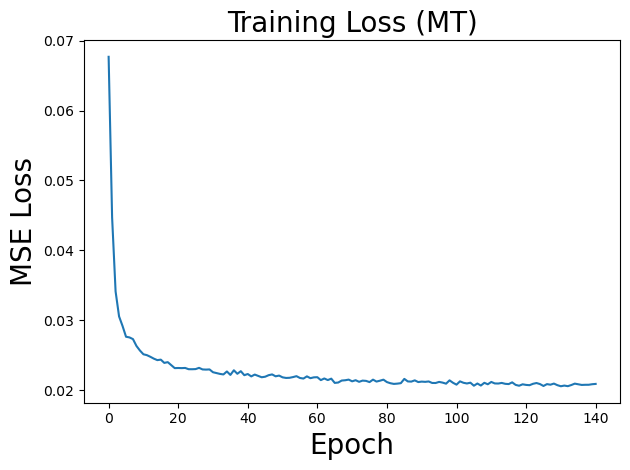

In [13]:
# Plotting training loss
plt.figure()
plt.plot(loss_per_epoch_mt[0:])
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('MSE Loss', fontsize=20)
plt.title('Training Loss (MT)', fontsize=20)
plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.savefig(f'{subject_glu_nn_image_path}/mt_loss.jpeg', bbox_inches='tight')
plt.show()

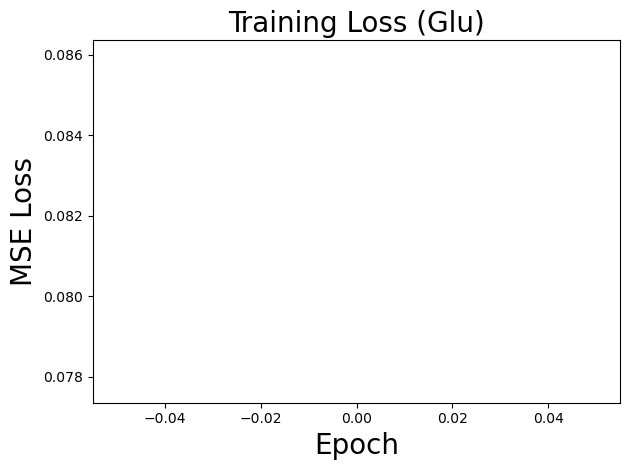

In [14]:
# Plotting training loss
plt.figure()
plt.plot(loss_per_epoch[0:])
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('MSE Loss', fontsize=20)
plt.title('Training Loss (Glu)', fontsize=20)
plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.savefig(f'{subject_glu_nn_image_path}/glu_loss.jpeg', bbox_inches='tight')
plt.show()

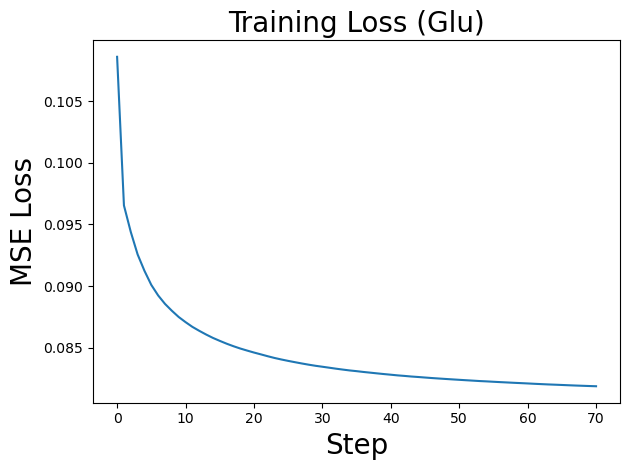

In [15]:
# Plotting training loss
plt.figure()
plt.plot(loss_per_step[0:])
plt.xlabel('Step', fontsize=20)
plt.ylabel('MSE Loss', fontsize=20)
plt.title('Training Loss (Glu)', fontsize=20)
plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.savefig(f'{subject_glu_nn_image_path}/glu_loss_step.jpeg', bbox_inches='tight')
plt.show()